# Exploratory Analysis
- Pull daily ticker data for crypto assets (specify SYMBOL:CURRENCY Pair)
- Visualize data (line plots, candlestick charts etc.)

In [1]:
import os
import time
from tqdm.auto import tqdm
from pathlib import Path

os.chdir("..")

In [63]:
import pandas as pd
import mplfinance as mpf

from get_ohlcv import get_top_cryptos, get_yahoo_ticker_data
from src.plots import *

plt.rcParams["figure.figsize"] = (24, 5)

# Load Data

In [3]:
dftop = get_top_cryptos()

topn = 100  # grab the largest topn by market cap
ticker_list = dftop.head(topn)["ticker"].tolist()
ticker_list[0:10]

['BTC-USD',
 'ETH-USD',
 'XRP-USD',
 'USDT-USD',
 'BNB-USD',
 'SOL-USD',
 'USDC-USD',
 'DOGE-USD',
 'ADA-USD',
 'STETH-USD']

# Choose Ticker for Analysis

In [5]:
ticker = ticker_list[1]

df = get_yahoo_ticker_data(ticker)

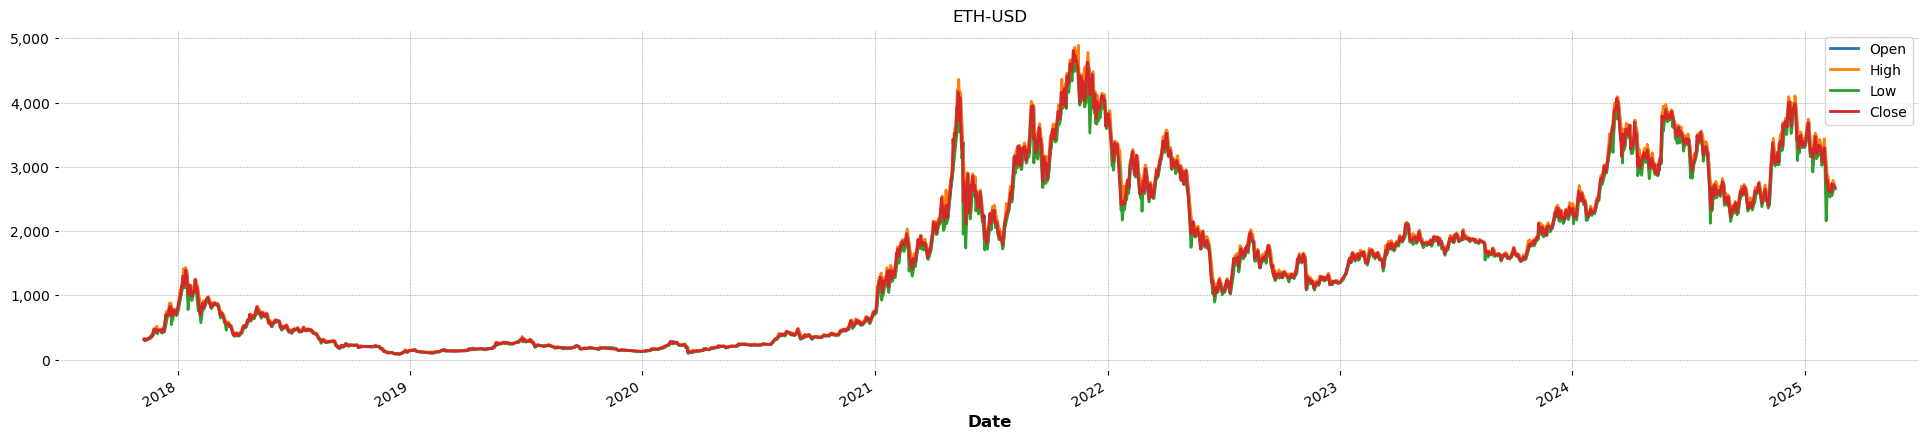

In [64]:
fig, ax = plt.subplots()
df.set_index("Date")[["Open", "High", "Low", "Close"]].plot(ax=ax, title=f"{ticker}")
format_yaxis_thousands(ax)

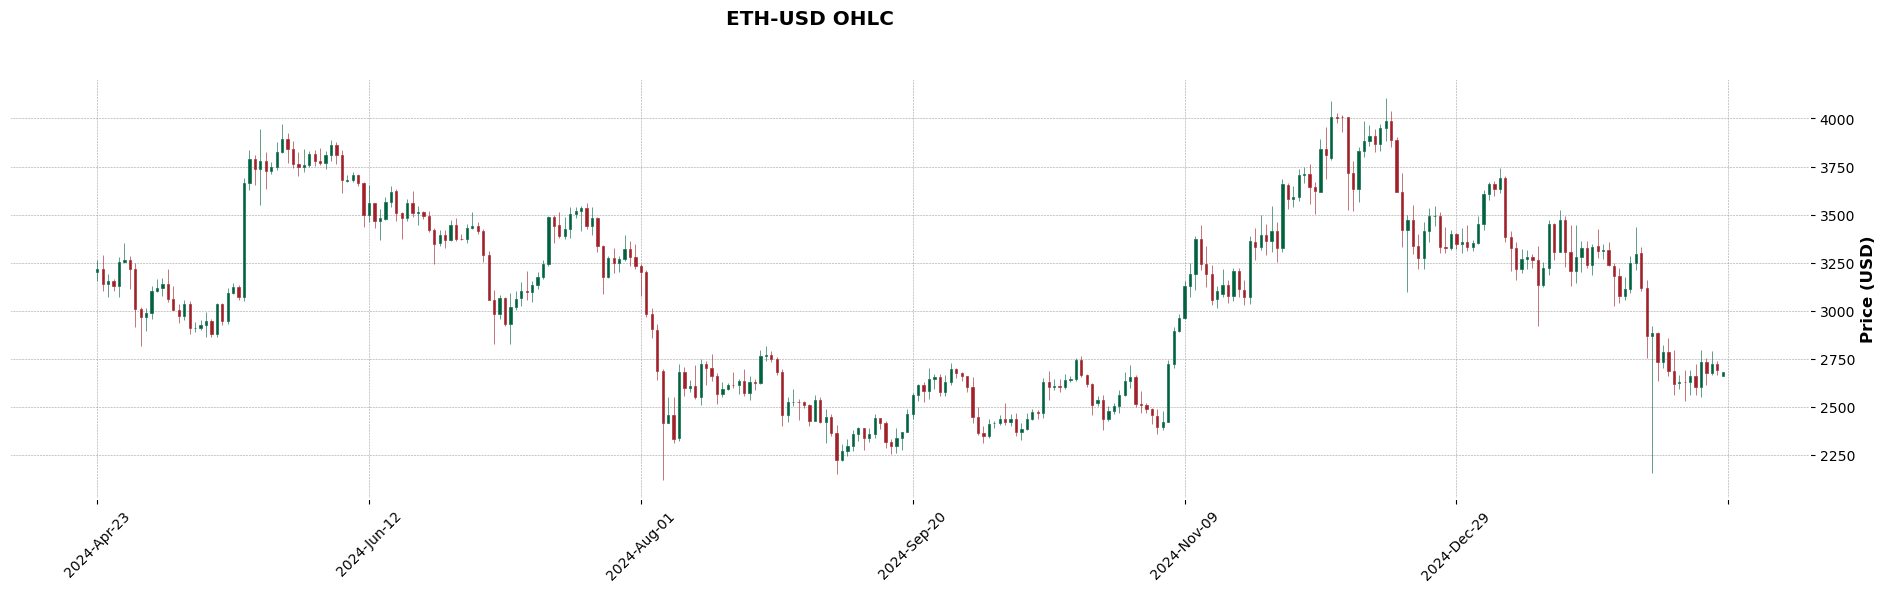

In [56]:
data = df.set_index("Date")[["Open", "High", "Low", "Close"]]
mpf.plot(data.tail(300), type="candle", style="charles", title=f"{ticker} OHLC", ylabel="Price (USD)", figsize=(25, 6))

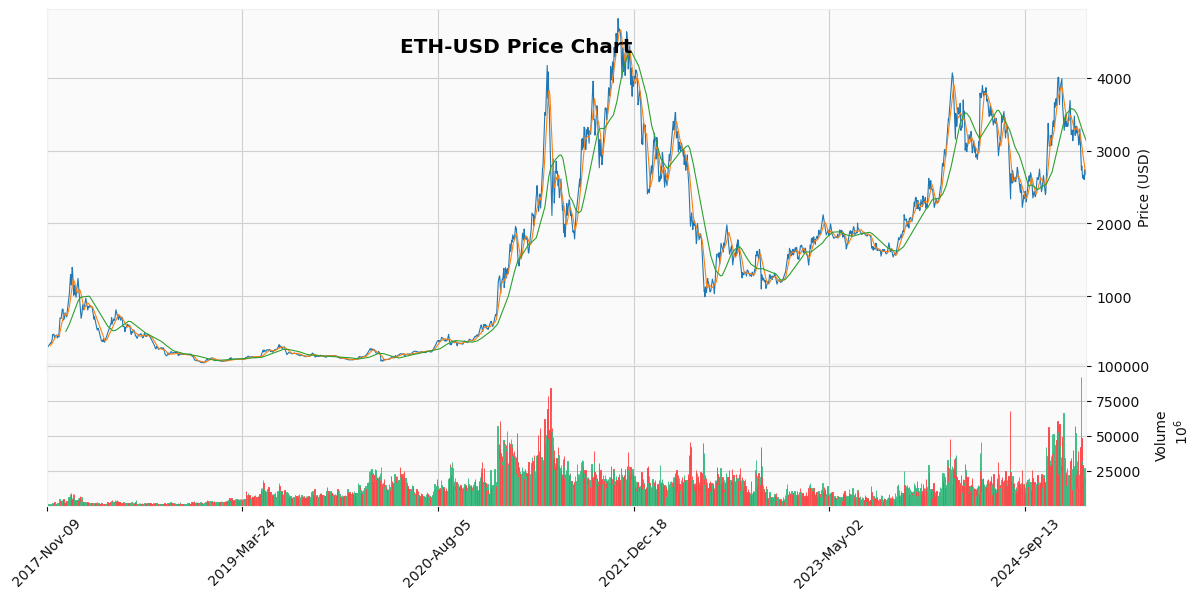

In [57]:
ohlcv_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

mpf.plot(df.set_index("Date")[ohlcv_cols], 
         # type="candle", 
         style="yahoo",  # Dark mode theme
         title=f"{ticker} Price Chart",
         ylabel="Price (USD)",
         ylabel_lower="Volume",
         volume=True,
         type="line",
         mav=(10, 50),       # 10-day & 50-day moving averages
         figratio=(25, 12),  # Adjust figure size
         tight_layout=True)

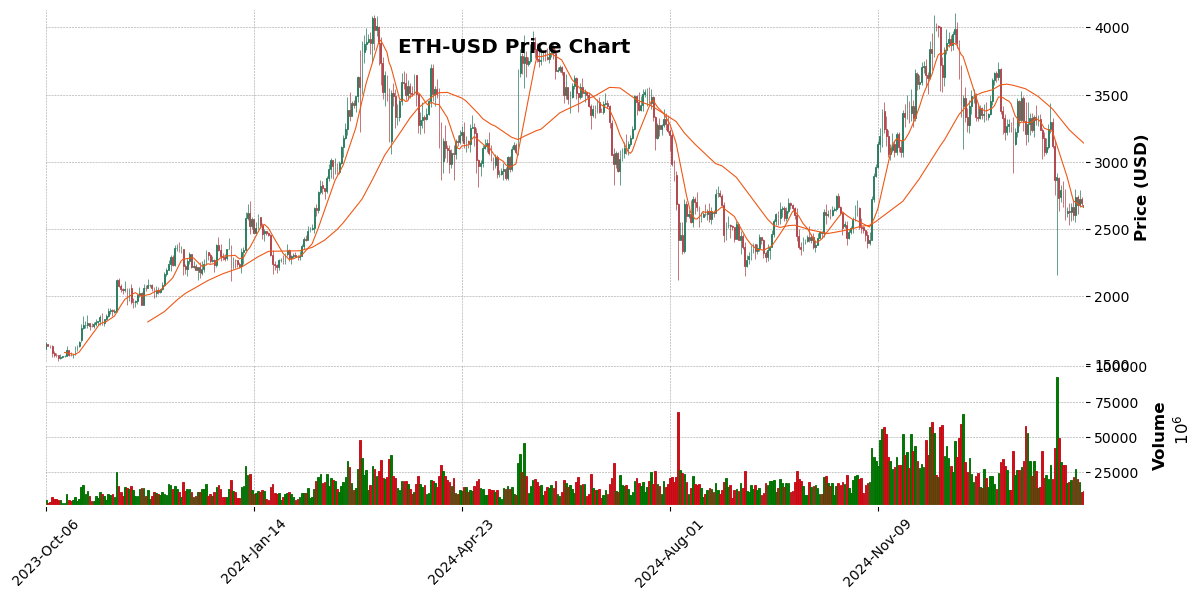

In [58]:
mpf.plot(df.set_index("Date")[ohlcv_cols].tail(500), 
         type="candle", 
         style="charles",  # Dark mode theme
         title=f"{ticker} Price Chart",
         ylabel="Price (USD)",
         ylabel_lower="Volume",
         volume=True,        # Shows volume in lower plot
         mav=(10, 50),       # 10-day & 50-day moving averages
         figratio=(25, 12),  # Adjust figure size
         tight_layout=True)

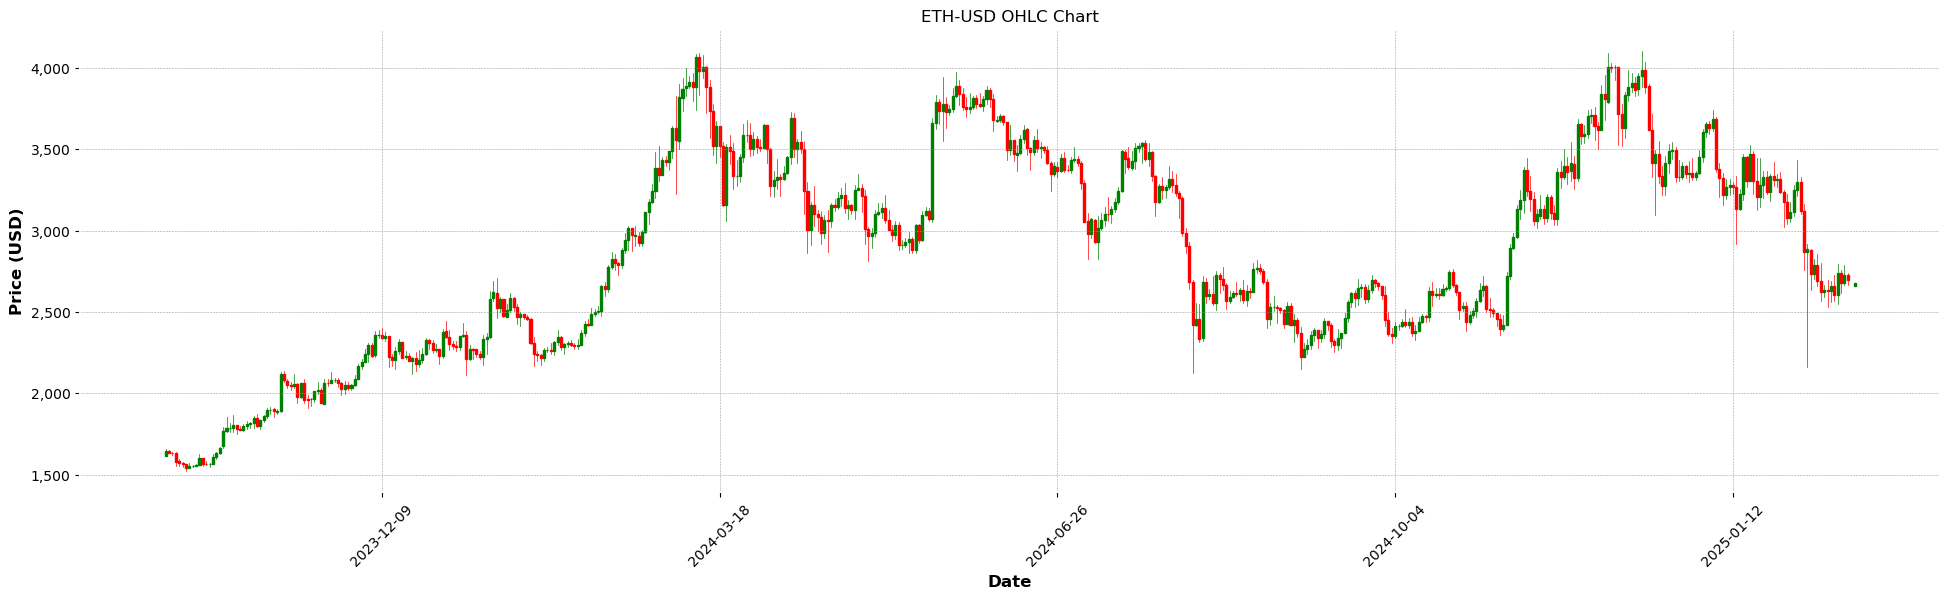

In [49]:
# More Candlestick Charts

import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc

# # Convert timestamp to Matplotlib date format
df_reset = df.tail(500).copy()
df_reset["Date"] = df_reset["Date"].map(mdates.date2num)

fig, ax = plt.subplots(figsize=(24, 6))
candlestick_ohlc(ax, df_reset[["Date"] + ohlcv_cols].values, width=0.6, colorup="green", colordown="red")

# Formatting the date labels
format_yaxis_thousands(ax)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)
plt.title(f"{ticker} OHLC Chart")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

In [66]:
from scipy import stats
import statsmodels.api as sm

<Axes: xlabel='Date'>

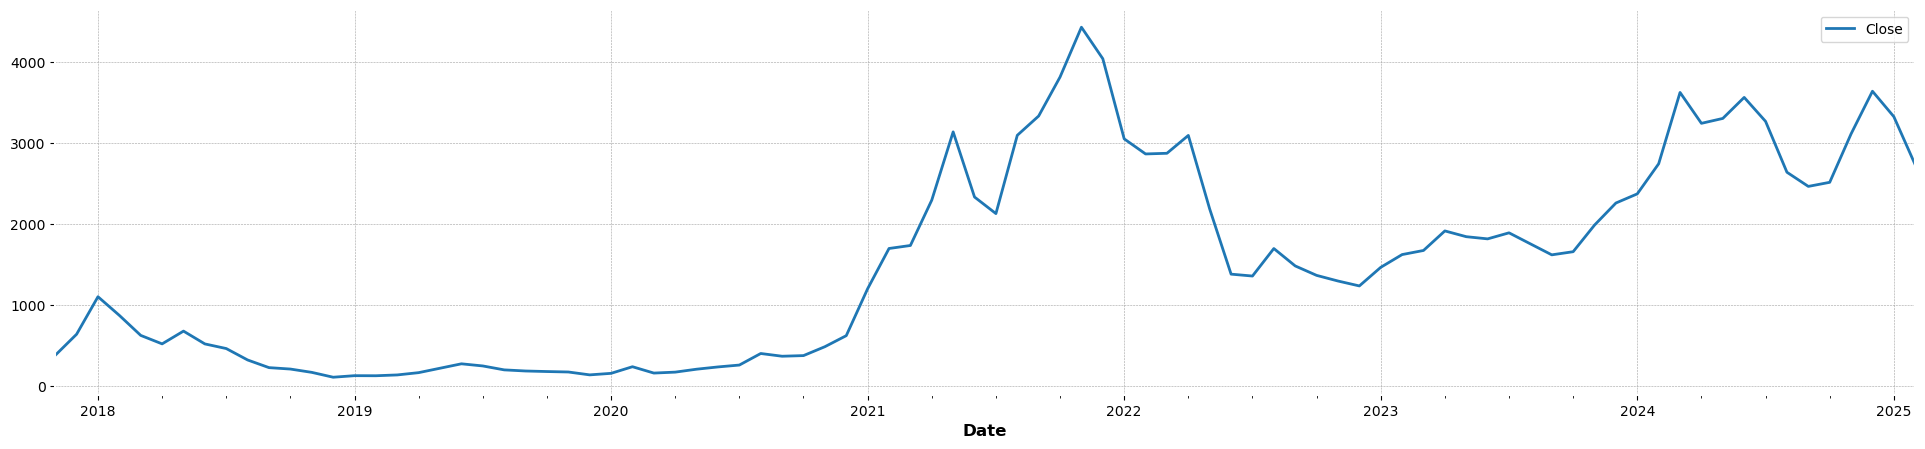

In [70]:
df_monthly = df.set_index("Date").resample("ME")[["Close"]].mean()
df_monthly.plot()

In [71]:
df_monthly

,Close
Date,
2017-11-30 00:00:00+00:00,379.732093
2017-12-31 00:00:00+00:00,640.209291
2018-01-31 00:00:00+00:00,1103.646004
2018-02-28 00:00:00+00:00,873.116318
2018-03-31 00:00:00+00:00,625.761325
...,...
2024-10-31 00:00:00+00:00,2517.521075
2024-11-30 00:00:00+00:00,3116.282096
2024-12-31 00:00:00+00:00,3643.111375


np.float64(0.5561345627975126)

<Figure size 2400x1000 with 0 Axes>

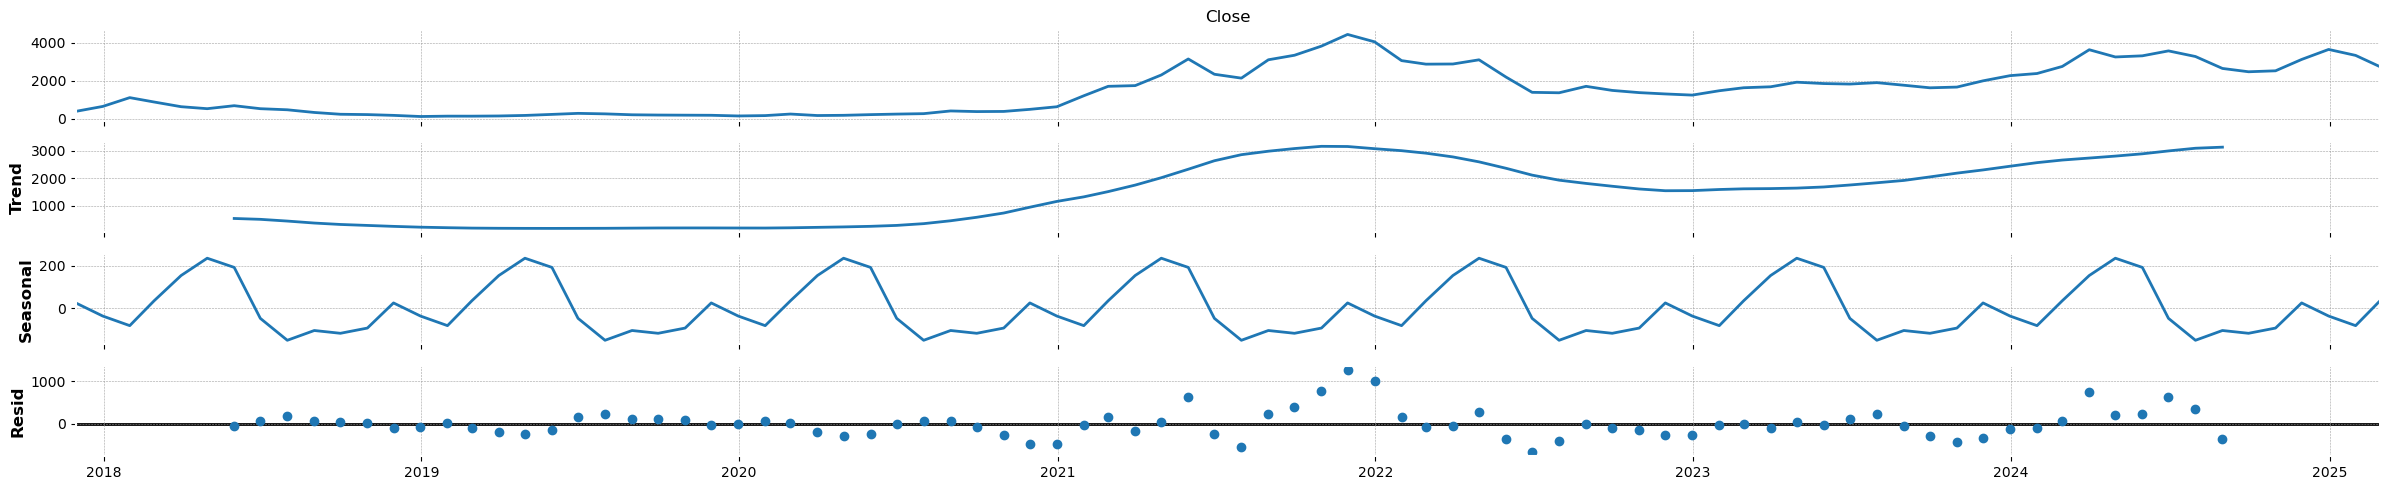

In [79]:
plt.figure(figsize=[24, 10])
sm.tsa.seasonal_decompose(df_monthly["Close"]).plot();
# print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])

In [88]:
adf = sm.tsa.stattools.adfuller(df_monthly.Close)[1]
stationary = bool(adf < .05)

print(f"Monthly {ticker} Stationary: {stationary}")
print(f"""Augmented Dickey Fuller (ADF) = {adf:.3}""")

Monthly ETH-USD Stationary: False
Augmented Dickey Fuller (ADF) = 0.556


# StatsModels

In [17]:
from statsforecast import StatsForecast
from statsforecast.models import AutoETS

os.environ["NIXTLA_ID_AS_COL"] = "1"

In [111]:
freq = "D"
freq = "ME"
freq = "W-SUN"
label = "Close"

dffit = df.rename(columns={"Ticker": "unique_id", "Date": "ds", label: "y"})[["unique_id", "ds", "y"]]
dffit = dffit.groupby(["unique_id", pd.Grouper(key="ds", freq=freq)])[["y"]].mean().reset_index()
# dffit.plot(x="ds", y="y", figsize=(24, 5))

<Axes: xlabel='ds'>

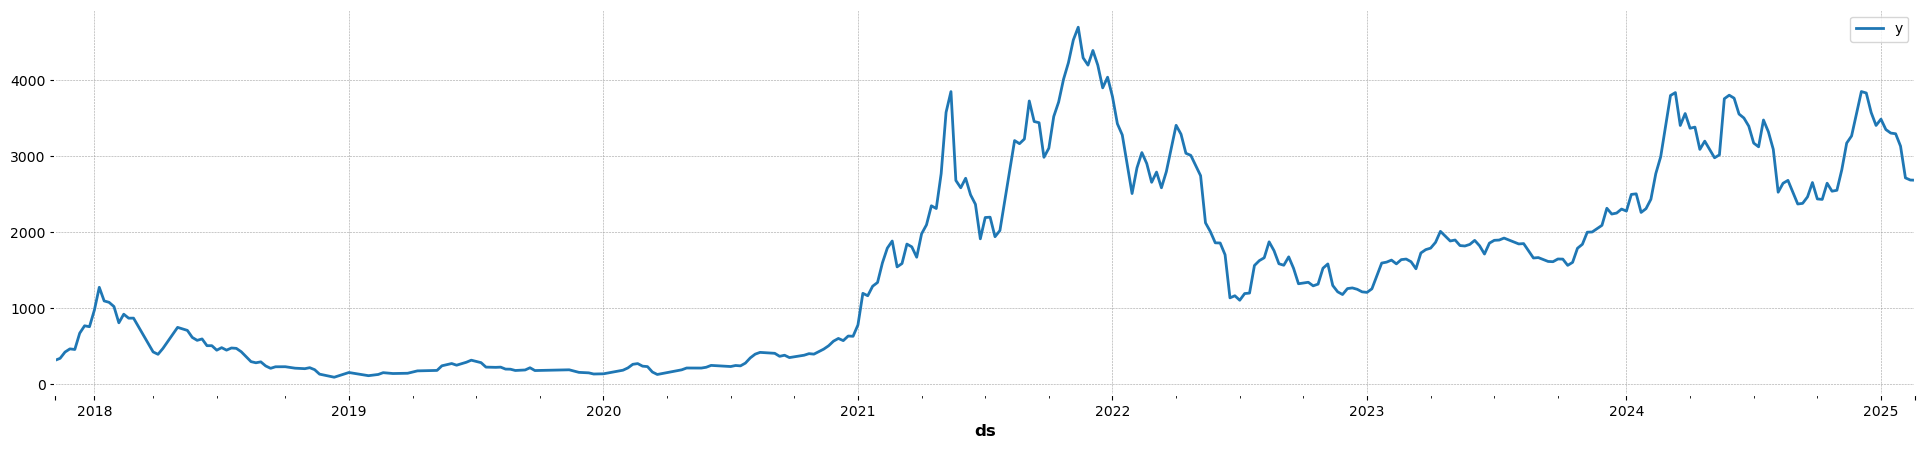

In [112]:
dffit = dffit
dffit.plot(x="ds", y="y", figsize=(24, 5))

In [113]:
MODEL_LIST = [
    AutoETS(season_length=12),
    # AutoARIMA(season_length=12),
]
sf = StatsForecast(models=MODEL_LIST, freq=freq)
sf.fit(dffit)
fcast = sf.forecast(12, dffit)

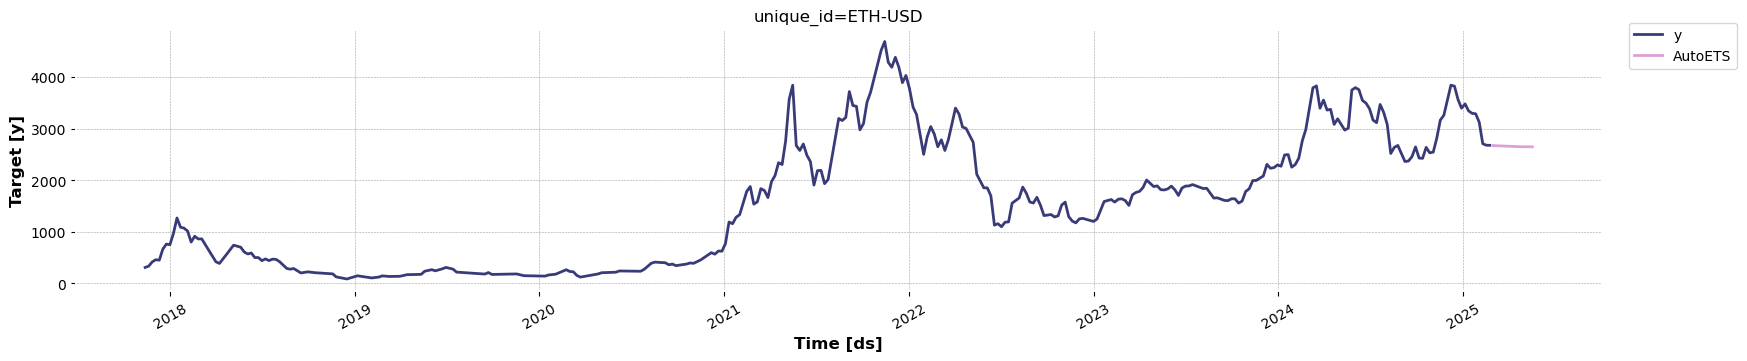

In [114]:
sf.plot(dffit, fcast)

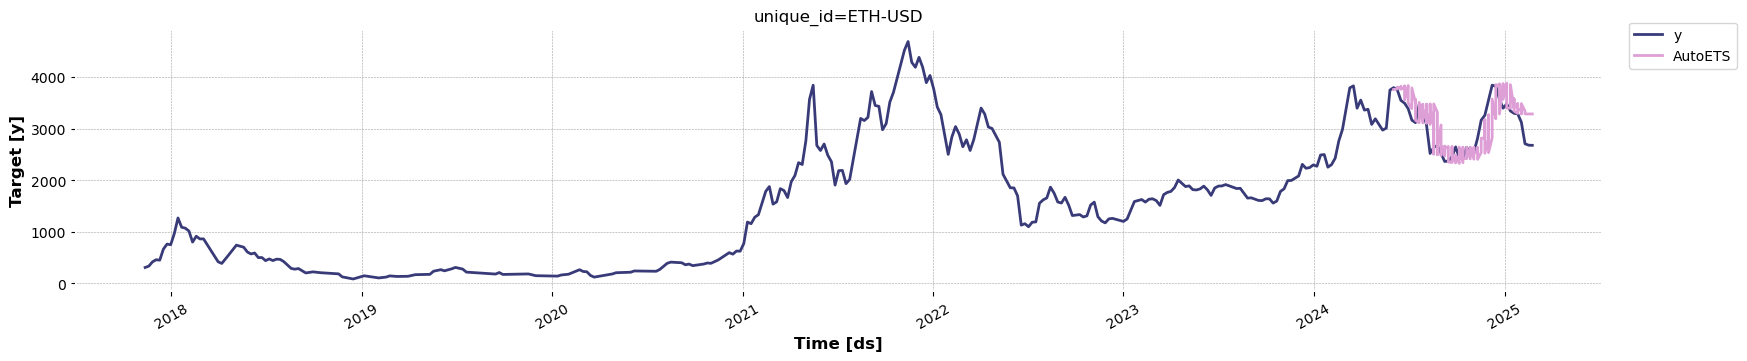

In [116]:
df_cv = sf.cross_validation(h=4, n_windows=36, df=dffit)
sf.plot(dffit, df_cv.drop(["y"], axis="columns"), models=[str(m) for m in sf.models])